In [53]:
# code by Swati Kar
# email: swati.cse.ruet@gmail.com

#necessary packages
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import math
import random
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback



In [54]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class EarlyStoppingCallback(BaseCallback):
    def __init__(self, patience: int, min_delta: float = 0.0, verbose: int = 0):
        """
        Early stopping callback to stop training when a monitored metric stops improving.

        :param patience: Number of steps to wait for improvement before stopping.
        :param min_delta: Minimum change to qualify as an improvement.
        :param verbose: Verbosity level (0: no output, 1: output when stopping).
        """
        super(EarlyStoppingCallback, self).__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.best_reward = -np.inf
        self.wait = 0

    def _on_step(self) -> bool:
        # Access the latest reward from the training environment
        if "episode" in self.locals["infos"][0]:
            episode_reward = self.locals["infos"][0]["episode"]["r"]
            if episode_reward > self.best_reward + self.min_delta:
                self.best_reward = episode_reward
                self.wait = 0  # Reset the patience counter
            else:
                self.wait += 1

            if self.wait >= self.patience:
                if self.verbose > 0:
                    print(f"Early stopping triggered. Best reward: {self.best_reward}")
                return False  # Stop training

        return True  # Continue training

In [55]:

# environment code
class FighterJetEnv(gym.Env):
    def __init__(self):
        super(FighterJetEnv, self).__init__()

        # Initialize Pygame
        pygame.init()
        self.width = 800
        self.height = 800
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("V14_exp_extend Fighter Jet Game")


        # Initialize font for text rendering
        self.font = pygame.font.Font(None, 20)

        # Add a semi-transparent surface for text background
        self.text_surface = pygame.Surface((200, 100))
        self.text_surface.set_alpha(128)
        self.text_surface.fill((0, 0, 0))
        self.dot_spacing = 2  # Adjust this value to change the spacing between dots

        # Update colors
        self.WHITE = (255, 255, 255)
        self.RED = (255, 0, 0)
        self.BLUE = (0, 0, 255)
        self.LIGHT_BLUE = (100, 100, 255)  # Darker shade of light blue for better visibility

        

        # New colors
        self.LIGHT_GREEN = (200, 255, 200)  # Very light green for background
        self.DARK_GREEN = (0, 100, 0)  # Dark green for agent and bullets

        

        # Update background color
        self.background = pygame.Surface((self.width, self.height))
        self.background.fill(self.LIGHT_GREEN)

        # Game parameters
        # self.jet_speed = 3
        self.bullet_speed = 7
        self.targeting_zone_radius = 200
        self.enemy_observation_radius = 250
        self.agent_observation_radius = self.targeting_zone_radius
        self.max_speed = 3
        self.min_speed = 0
        self.acceleration = 0.25
        self.turn_rate = 0.05
        self.current_speed = self.min_speed
        self.good_shooting_distance_threshold = 50

        # Update enemy parameters
        self.enemy_speed = 4
        self.enemy_bullet_speed = 7
        self.enemy_shoot_interval = 5 
        self.enemy_max_bullets = 1000


        # Define action and observation space
        # Actions: 0: do nothing, 1: turn left, 2: turn right, 3: accelerate, 4: decelerate, 5: shoot
        self.action_space = spaces.Discrete(6)

        self.obs_ranges = {
            'jet_pos_x': (0, self.width),
            'jet_pos_y': (0, self.height),
            'jet_orientation': (-math.pi, math.pi),
            'jet_velocity_x': (-self.max_speed, self.max_speed),
            'jet_velocity_y': (-self.max_speed, self.max_speed),
            'angle_to_target': (-math.pi, math.pi),
            'dist_to_target': (0, math.sqrt(self.width**2 + self.height**2)),
            'enemy_visible': (0, 1),
            'angle_to_enemy': (-math.pi, math.pi),
            'dist_to_enemy': (0, math.sqrt(self.width**2 + self.height**2)),
            'bullet_visible': (0, 1),
            'dist_to_bullet': (0, math.sqrt(self.width**2 + self.height**2)),
            'in_target_zone': (0, 1)
        }

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(13,), dtype=np.float32)

        self.clock = pygame.time.Clock()

        self.edge_buffer = 20

        self.in_target_zone = False
        self.enemy_visible = False

        # attributes for episode limit and bullet optimization
        self.max_steps = 2000
        self.current_step = 0
        self.max_bullets = 50
        self.bullet_count = 0

        self.current_reward = 0
        self.episode_reward = 0
        self.episode = 0
        
        self.agent_status = "Game started"

        self.action_counts = [0] * 6
        self.action_rewards = [0] * 6
        self.last_action = None
        self.last_state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        print("Reset environment")
        self.episode += 1
        # Reset jet, enemy, target positions and other game states
        self.jet_pos = np.array([self.width // 2, self.height - 50], dtype=np.float32)
        self.jet_orientation = -math.pi / 2 
        self.current_speed = self.min_speed
        self.jet_velocity = self.current_speed * np.array([math.cos(self.jet_orientation), math.sin(self.jet_orientation)])
        self.enemy_pos = np.array([self.width // 2, 50], dtype=np.float32)
        self.target_pos = np.array([random.randint(50, self.width-50), random.randint(50, self.height-50)], dtype=np.float32)
        self.jet_bullets = []
        self.enemy_bullets = []
        self.enemy_shoot_counter = 0
        self.enemy_bullet_count = 0
        self.in_target_zone = False
        self.enemy_visible = False

        self.current_step = 0
        self.bullet_count = 0

        self.action_counts = [0] * 6
        self.action_rewards = [0] * 6
        self.last_action = None
        self.last_state = None

        self.current_reward = 0
        self.episode_reward = 0
        self.agent_status = "Game started"

        obs = self._get_obs()
        return obs, {} 

    def step(self, action):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return self._get_obs(), 0, True, False, {}
            
        prev_jet_pos = self.jet_pos.copy()
            
        # Process action
        if action == 0:  # Do nothing
            pass
        elif action == 1:  # Turn left
            self.jet_orientation -= self.turn_rate
        elif action == 2:  # Turn right
            self.jet_orientation += self.turn_rate
        elif action == 3:  # Accelerate
            self.current_speed = min(self.current_speed + self.acceleration, self.max_speed)
        elif action == 4:  # Decelerate
            self.current_speed = max(self.current_speed - self.acceleration, self.min_speed)
        if action == 5:  # Shoot
            self.bullet_count += 1
            bullet_velocity = self.bullet_speed * np.array([math.cos(self.jet_orientation), math.sin(self.jet_orientation)])
            self.jet_bullets.append([self.jet_pos.copy(), bullet_velocity])

        # Move jet forward in the direction it's facing
        self.jet_velocity = self.current_speed * np.array([math.cos(self.jet_orientation), math.sin(self.jet_orientation)])
        new_pos = self.jet_pos + self.jet_velocity

        

        # Check for out-of-bounds
        if new_pos[0] < self.edge_buffer or new_pos[0] > self.width - self.edge_buffer:
            self.jet_orientation = math.pi - self.jet_orientation
            self.jet_orientation = (self.jet_orientation + math.pi) % (2 * math.pi) - math.pi
            new_pos[0] = max(min(new_pos[0], self.width - self.edge_buffer - 1), self.edge_buffer + 1)

        if new_pos[1] < self.edge_buffer or new_pos[1] > self.height - self.edge_buffer:
            self.jet_orientation = -self.jet_orientation
            self.jet_orientation = (self.jet_orientation + math.pi) % (2 * math.pi) - math.pi
            new_pos[1] = max(min(new_pos[1], self.height - self.edge_buffer - 1), self.edge_buffer + 1)

        self.jet_pos = new_pos


       # Update in_target_zone and enemy_visible status
        self.in_target_zone = np.linalg.norm(self.jet_pos - self.target_pos) <= self.targeting_zone_radius
        self.enemy_visible = self.enemy_pos is not None and np.linalg.norm(self.jet_pos - self.enemy_pos) <= self.enemy_observation_radius

        # Move bullets
        for bullet in self.jet_bullets:
            bullet[0] += bullet[1]
        self.jet_bullets = [bullet for bullet in self.jet_bullets if 0 <= bullet[0][0] <= self.width and 0 <= bullet[0][1] <= self.height]

        for bullet in self.enemy_bullets:
            bullet[0] += bullet[1]
        self.enemy_bullets = [bullet for bullet in self.enemy_bullets if 0 <= bullet[0][0] <= self.width and 0 <= bullet[0][1] <= self.height]

        

        # enemy behavior
        if self.enemy_pos is not None:
            dist_to_jet = np.linalg.norm(self.jet_pos - self.enemy_pos)
            direction = (self.jet_pos - self.enemy_pos) / dist_to_jet
            
            if dist_to_jet > 100:
                self.enemy_pos += direction * self.enemy_speed
            elif dist_to_jet < 50:
                self.enemy_pos -= direction * self.enemy_speed
            else:
                self.enemy_pos += np.random.uniform(-0.5, 0.5, 2) * self.enemy_speed

            self.enemy_pos = np.clip(self.enemy_pos, self.edge_buffer, [self.width - self.edge_buffer, self.height - self.edge_buffer])

            self.enemy_shoot_counter += 1
            if self.enemy_shoot_counter >= self.enemy_shoot_interval and self.enemy_bullet_count < self.enemy_max_bullets:
                bullet_velocity = self.enemy_bullet_speed * direction
                self.enemy_bullets.append([self.enemy_pos.copy(), bullet_velocity])
                self.enemy_bullet_count += 1
                self.enemy_shoot_counter = 0

        done = False
        reward = 0
        
        # Small negative reward for each step to encourage efficiency
        reward -= 0.1

        # Calculate distances
        prev_dist_to_target = np.linalg.norm(self.target_pos - prev_jet_pos)
        current_dist_to_target = np.linalg.norm(self.target_pos - self.jet_pos)
        # print(f"prev_dist_to_target: {prev_dist_to_target} |current_dist_to_target: {current_dist_to_target} ")
        
        # Calculate reward
        distance_change = prev_dist_to_target - current_dist_to_target
        distance_weight = 10  # Increased from 5 to 10
        reward += distance_change * distance_weight

        # Add an additional penalty for moving away from the target
        if distance_change < 0:
            moving_away_penalty = abs(distance_change) * 15  # Additional penalty
            reward -= moving_away_penalty

        
        if self.in_target_zone:
            reward += 2
            self.agent_status = "Agent in target zone"
        else:
            reward += -1
            self.agent_status = "Agent out of target zone"

        if self.enemy_visible:
            reward += 1
            self.agent_status = "Enemy visible"
        else:
            reward -= 0.5

        if self.bullet_count > self.max_bullets:
            reward -= 0.5
            self.agent_status = "Excessive bullet usage"


        if self.in_target_zone and any(np.linalg.norm(bullet[0] - self.target_pos) < 15 for bullet in self.jet_bullets):
            reward += 200
            done = True
            self.agent_status = "Agent hit target within target zone"

        if self.enemy_visible and self.enemy_pos is not None and any(np.linalg.norm(bullet[0] - self.enemy_pos) < 15 for bullet in self.jet_bullets):
            reward += 100
            self.agent_status = "Agent hit enemy"
            self.enemy_pos = None
            self.enemy_visible = False
            self.enemy_bullets = []

        if self.enemy_visible and any(np.linalg.norm(bullet[0] - self.jet_pos) < 15 for bullet in self.enemy_bullets):
            reward += -500
            done = True
            self.agent_status = "Enemy hit agent"

        # Check if max steps reached
        if self.current_step >= self.max_steps:
            reward -= 1000 
            done = True
            self.agent_status = "Max steps reached without hitting target"

        self.last_state = self._get_obs()
        self.last_action = action
        self.action_counts[action] += 1
        self.action_rewards[action] += reward

        self.current_step += 1
        self.episode_reward += reward
        self.current_reward = reward
        self.render()
        return self._get_obs(), reward, done, False, {"status": self.agent_status, "episode_reward": self.episode_reward}
      

    def _get_obs(self):
        jet_to_target = self.target_pos - self.jet_pos
        
        angle_to_target = math.atan2(jet_to_target[1], jet_to_target[0])
        dist_to_target = np.linalg.norm(jet_to_target)
        
        if self.enemy_pos is not None and self.enemy_visible:
            jet_to_enemy = self.enemy_pos - self.jet_pos
            angle_to_enemy = math.atan2(jet_to_enemy[1], jet_to_enemy[0])
            dist_to_enemy = np.linalg.norm(jet_to_enemy)
        else:
            angle_to_enemy = 0
            dist_to_enemy = self.enemy_observation_radius

        closest_enemy_bullet = min(self.enemy_bullets, key=lambda bullet: np.linalg.norm(bullet[0] - self.jet_pos)) if self.enemy_bullets else [self.jet_pos, np.zeros(2)]
        jet_to_bullet = closest_enemy_bullet[0] - self.jet_pos
        angle_to_bullet = math.atan2(jet_to_bullet[1], jet_to_bullet[0])
        dist_to_bullet = np.linalg.norm(jet_to_bullet)
        bullet_visible = int(len(self.enemy_bullets) > 0)

        obs = [
            self.jet_pos[0],
            self.jet_pos[1],
            self.jet_orientation,
            self.jet_velocity[0],
            self.jet_velocity[1],
            angle_to_target,
            dist_to_target,
            int(self.enemy_pos is not None and self.enemy_visible),
            angle_to_enemy,
            dist_to_enemy,
            bullet_visible,
            dist_to_bullet,
            int(self.in_target_zone)
        ]

        # Normalize observations
        normalized_obs = [
            (obs[i] - self.obs_ranges[key][0]) / (self.obs_ranges[key][1] - self.obs_ranges[key][0])
            for i, key in enumerate(self.obs_ranges.keys())
        ]

        return np.array(normalized_obs, dtype=np.float32)
    
    def draw_dotted_circle(self, surface, color, center, radius, width=1):

        for i in range(0, 360, self.dot_spacing):

            angle = i * math.pi / 180

            start_pos = (center[0] + int(radius * math.cos(angle)),

                        center[1] + int(radius * math.sin(angle)))

            end_pos = (center[0] + int(radius * math.cos(angle + math.pi / 180)),

                    center[1] + int(radius * math.sin(angle + math.pi / 180)))

            pygame.draw.line(surface, color, start_pos, end_pos, width)

    def render(self):
        # Fill the background with light green
        self.screen.blit(self.background, (0, 0))
        
        # Draw targeting zone
        self.draw_dotted_circle(self.screen, self.LIGHT_BLUE, self.target_pos.astype(int), self.targeting_zone_radius, 2)
        
        # Draw observation ranges
        self.draw_dotted_circle(self.screen, self.DARK_GREEN, self.jet_pos.astype(int), self.agent_observation_radius, 1)        
       
        # Draw jet
        jet_direction = np.array([math.cos(self.jet_orientation), math.sin(self.jet_orientation)])
        jet_nose = self.jet_pos + 20 * jet_direction
        jet_left = self.jet_pos + 10 * np.array([-jet_direction[1], jet_direction[0]])
        jet_right = self.jet_pos + 10 * np.array([jet_direction[1], -jet_direction[0]])
        pygame.draw.polygon(self.screen, self.DARK_GREEN, [jet_nose, jet_left, jet_right])

        if self.enemy_pos is not None:
            self.draw_dotted_circle(self.screen, self.RED, self.enemy_pos.astype(int), self.enemy_observation_radius, 1)
            enemy_direction = (self.jet_pos - self.enemy_pos) / np.linalg.norm(self.jet_pos - self.enemy_pos)
            enemy_nose = self.enemy_pos + 20 * enemy_direction
            enemy_left = self.enemy_pos + 10 * np.array([-enemy_direction[1], enemy_direction[0]])
            enemy_right = self.enemy_pos + 10 * np.array([enemy_direction[1], -enemy_direction[0]])
            pygame.draw.polygon(self.screen, self.RED, [enemy_nose, enemy_left, enemy_right])
        
        pygame.draw.circle(self.screen, self.BLUE, self.target_pos.astype(int), 15)
        
        for bullet in self.jet_bullets:
            pygame.draw.circle(self.screen, self.DARK_GREEN, bullet[0].astype(int), 3)
        for bullet in self.enemy_bullets:
            pygame.draw.circle(self.screen, self.RED, bullet[0].astype(int), 3)

        text_color = (0, 0, 0)  # Black text

        status_text = self.font.render(f"Episode: {self.episode}", True, text_color)
        self.screen.blit(status_text, (15, 15))


        reward_text = self.font.render(f"Reward: {self.episode_reward:.2f}", True, text_color)
        self.screen.blit(reward_text, (15, 35))


        step_text = self.font.render(f"Steps: {self.current_step}/{self.max_steps}", True, text_color)
        self.screen.blit(step_text, (15, 55))


        bullet_text = self.font.render(f"Bullets: {self.bullet_count}/{self.max_bullets}", True, text_color)
        self.screen.blit(bullet_text, (15, 75))

        pygame.display.flip()
        self.clock.tick(60)

    def close(self):
        pygame.quit()

In [56]:
import gymnasium as gym
from stable_baselines3 import DQN
# from stable_baselines3.dqn import DDQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import torch

class TensorboardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_reward = 0
        self.q_values = []

    def _on_step(self) -> bool:
        # Access the VecEnv
        env = self.training_env.envs[0]  # Extract the original environment
        if isinstance(env, Monitor):
            env = env.env  # Unwrap the Monitor to access the original FighterJetEnv

        self.episode_reward += self.locals['rewards'][0]

        # Log epsilon value
        epsilon = self.model.exploration_rate
        self.logger.record("exploration/epsilon", epsilon)

        # Log Q-values
        obs = self.locals['new_obs']
        with torch.no_grad():
            q_values = self.model.q_net(torch.as_tensor(obs).to(self.model.device))
        q_values = q_values.cpu().numpy()
        self.q_values.append(q_values)

        if self.locals['dones']:
            self.episode_lengths.append(self.locals['infos'][0]['episode']['l'])
            self.logger.record('main/ep_rew_total', self.episode_reward)
            self.logger.record('main/ep_len_mean', sum(self.episode_lengths) / len(self.episode_lengths))

            # Log Q-values
            mean_q_values = np.mean(self.q_values, axis=0)
            for i, q_value in enumerate(mean_q_values[0]):
                self.logger.record(f'q_values/action_{i}', q_value)
            self.logger.record('q_values/max', np.max(mean_q_values))
            self.logger.record('q_values/min', np.min(mean_q_values))
            self.logger.record('q_values/mean', np.mean(mean_q_values))

            # Print debug information
            print("Episode reward:", self.episode_reward)
            print("Total Steps:", self.episode_lengths[-1])
            print("Agent status:", env.agent_status)  # Access the original environment's attribute
            print("Mean Q-values:", mean_q_values[0])

            self.episode_reward = 0
        return True
    

# Create the callback
callback = TensorboardCallback()

In [57]:
def print_hyperparameters(model):
    print("\nDQN Hyperparameters:")
    print(f"Learning rate: {model.learning_rate}")
    print(f"Gamma (discount factor): {model.gamma}")
    print(f"Tau (soft update coefficient): {model.tau}")
    print(f"Train frequency: {model.train_freq}")
    print(f"Gradient steps: {model.gradient_steps}")
    print(f"Batch size: {model.batch_size}")
    print(f"Learning starts: {model.learning_starts}")
    print(f"Buffer size: {model.buffer_size}")
    print(f"Target update interval: {model.target_update_interval}")
    print(f"Exploration initial epsilon: {model.exploration_initial_eps}")
    print(f"Exploration final epsilon: {model.exploration_final_eps}")
    print(f"Exploration fraction: {model.exploration_fraction}")
    print(f"Max gradient norm: {model.max_grad_norm}")
    print("\nPolicy network architecture:")
    print(model.policy)

In [ ]:

import os


# Create and wrap the environment
env = FighterJetEnv()
env = Monitor(env)  
env = DummyVecEnv([lambda: env])

# Set the model path
model_path = "fighter_jet_dqn_2.zip"

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

reload = False
# Check if a saved model exists
if os.path.exists(model_path) and reload:
    print(f"Loading existing model from {model_path}")
    model = DQN.load(model_path, env=env, tensorboard_log="./fighter_jet_dqn_2/",  device=device)
    print("Model loaded successfully. Continuing training...")
else:
    print("No existing model found. Creating a new DQN agent.")
    model = DQN(
        "MlpPolicy", 
        env, 
        verbose=0,
        tensorboard_log="./fighter_jet_dqn_2/",
        learning_rate=5e-5,
        buffer_size=500000,
        learning_starts=50000,
        batch_size=256,
        tau=0.001,
        gamma=0.99,
        train_freq=1,
        gradient_steps=1,
        target_update_interval=5000,
        exploration_fraction=0.7,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.1,
        max_grad_norm=10,
        policy_kwargs=dict(net_arch=[256, 256,256]),
        device=device
        # double_q=True
    )   

print_hyperparameters(model)
# Create the callback
callback = TensorboardCallback()
early_stopping_callback = EarlyStoppingCallback(patience=100000, min_delta=1.0, verbose=1)
# Train the agent
model.learn(
    total_timesteps=int(2e6),
    callback=[callback, early_stopping_callback],
    reset_num_timesteps=False
)

# model_path = "fighter_jet_dqn_v12.zip"
# Save the trained model
model.save(model_path)

print("Training completed and model saved.")

Using device: cpu
No existing model found. Creating a new DQN agent.

DQN Hyperparameters:
Learning rate: 5e-05
Gamma (discount factor): 0.99
Tau (soft update coefficient): 0.001
Train frequency: TrainFreq(frequency=1, unit=<TrainFrequencyUnit.STEP: 'step'>)
Gradient steps: 1
Batch size: 256
Learning starts: 50000
Buffer size: 500000
Target update interval: 5000
Exploration initial epsilon: 1.0
Exploration final epsilon: 0.1
Exploration fraction: 0.7
Max gradient norm: 10

Policy network architecture:
DQNPolicy(
  (q_net): QNetwork(
    (features_extractor): FlattenExtractor(
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (q_net): Sequential(
      (0): Linear(in_features=13, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=6, bias=True)
    )
  )
  (q_net_target): Q

In [59]:
class TensorboardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_reward = 0
        self.q_values = []

    def _on_step(self) -> bool:
        # Access the VecEnv
        env = self.training_env.envs[0]  # Extract the original environment
        if isinstance(env, Monitor):
            env = env.env  # Unwrap the Monitor to access the original FighterJetEnv

        self.episode_reward += self.locals['rewards'][0]

        # Log epsilon value
        epsilon = self.model.exploration_rate
        self.logger.record("exploration/epsilon", epsilon)

        # Log Q-values
        obs = self.locals['new_obs']
        with torch.no_grad():
            q_values = self.model.q_net(torch.as_tensor(obs).to(self.model.device))
        q_values = q_values.cpu().numpy()
        self.q_values.append(q_values)

        if self.locals['dones']:
            self.episode_lengths.append(self.locals['infos'][0]['episode']['l'])
            self.logger.record('main/ep_rew_total', self.episode_reward)
            self.logger.record('main/ep_len_mean', sum(self.episode_lengths) / len(self.episode_lengths))

            # Log Q-values
            mean_q_values = np.mean(self.q_values, axis=0)
            for i, q_value in enumerate(mean_q_values[0]):
                self.logger.record(f'q_values/action_{i}', q_value)
            self.logger.record('q_values/max', np.max(mean_q_values))
            self.logger.record('q_values/min', np.min(mean_q_values))
            self.logger.record('q_values/mean', np.mean(mean_q_values))

            # Print debug information
            print("Episode reward:", self.episode_reward)
            print("Total Steps:", self.episode_lengths[-1])
            print("Agent status:", env.agent_status)  # Access the original environment's attribute
            print("Mean Q-values:", mean_q_values[0])

            self.episode_reward = 0
        return True

In [60]:
class TensorboardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_reward = 0
        self.q_values = []

    def _on_step(self) -> bool:
        # Access the VecEnv
        env = self.training_env.envs[0]  # Extract the original environment
        if isinstance(env, Monitor):
            env = env.env  # Unwrap the Monitor to access the original FighterJetEnv

        self.episode_reward += self.locals['rewards'][0]

        # Log epsilon value
        epsilon = self.model.exploration_rate
        self.logger.record("exploration/epsilon", epsilon)

        # Log Q-values
        obs = self.locals['new_obs']
        with torch.no_grad():
            q_values = self.model.q_net(torch.as_tensor(obs).to(self.model.device))
        q_values = q_values.cpu().numpy()
        self.q_values.append(q_values)

        if self.locals['dones']:
            self.episode_lengths.append(self.locals['infos'][0]['episode']['l'])
            self.logger.record('main/ep_rew_total', self.episode_reward)
            self.logger.record('main/ep_len_mean', sum(self.episode_lengths) / len(self.episode_lengths))

            # Log Q-values
            mean_q_values = np.mean(self.q_values, axis=0)
            for i, q_value in enumerate(mean_q_values[0]):
                self.logger.record(f'q_values/action_{i}', q_value)
            self.logger.record('q_values/max', np.max(mean_q_values))
            self.logger.record('q_values/min', np.min(mean_q_values))
            self.logger.record('q_values/mean', np.mean(mean_q_values))

            # Print debug information
            print("Episode reward:", self.episode_reward)
            print("Total Steps:", self.episode_lengths[-1])
            print("Agent status:", env.agent_status)  # Access the original environment's attribute
            print("Mean Q-values:", mean_q_values[0])

            self.episode_reward = 0
        return True

In [61]:
import stable_baselines3
print(stable_baselines3.__version__)

2.6.0


In [ ]:
env = FighterJetEnv()
# env = Monitor(env)  # Wrap with Monitor to get episode stats
# env = DummyVecEnv([lambda: env])
jetArrray = []
targetArray = []
# Load the saved model
modelname = r"C:\Users\raced\Autonomous-Fighter-Jet-Navigation-and-Combat\fighter_jet_dqn_2.zip"
model = DQN.load(modelname)

# Test the loaded model
obs, _ = env.reset()
print(f"Initial observation shape: {obs.shape}")

for _ in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    jetArrray.append(env.jet_pos)
    targetArray.append(env.target_pos)
    if terminated or truncated:
        obs, _ = env.reset()


env.close()

Reset environment
Initial observation shape: (13,)
Reset environment


Available scalar tags: ['exploration/epsilon', 'main/ep_len_mean', 'main/ep_rew_total', 'q_values/action_0', 'q_values/action_1', 'q_values/action_2', 'q_values/action_3', 'q_values/action_4', 'q_values/action_5', 'q_values/max', 'q_values/mean', 'q_values/min', 'rollout/ep_len_mean', 'rollout/ep_rew_mean', 'rollout/exploration_rate', 'time/fps', 'train/learning_rate', 'train/loss']


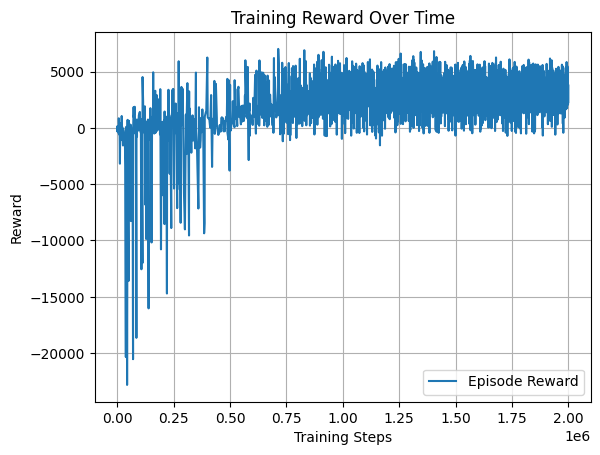

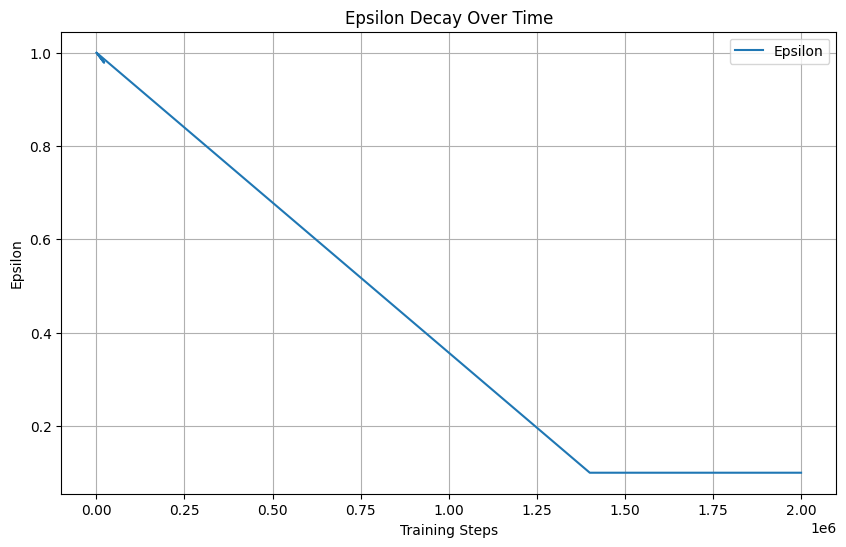

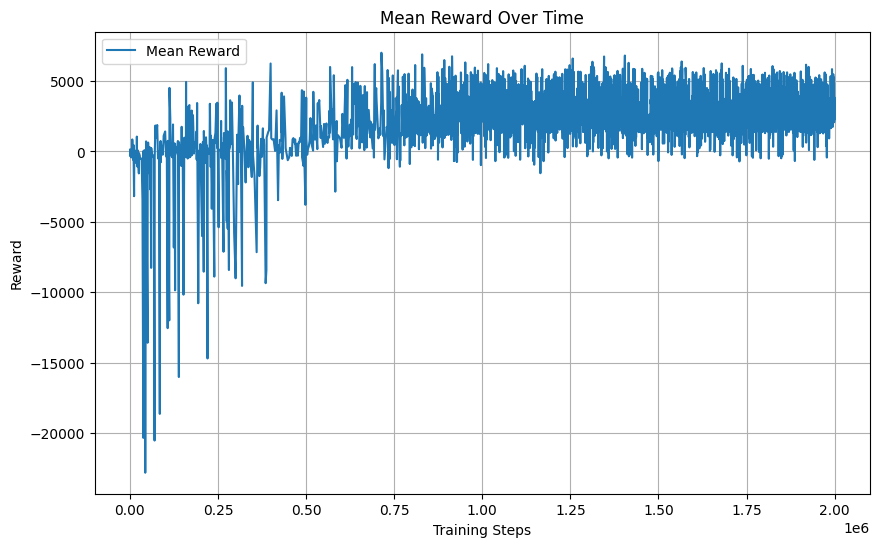

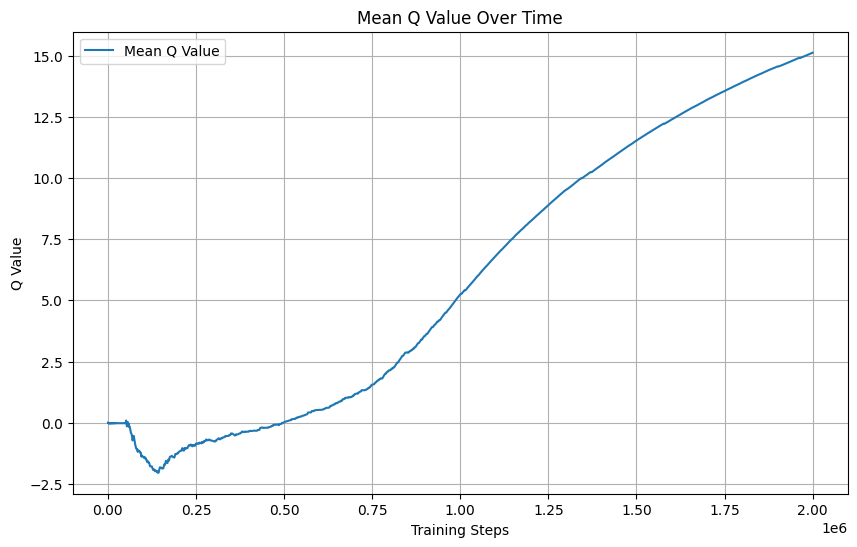

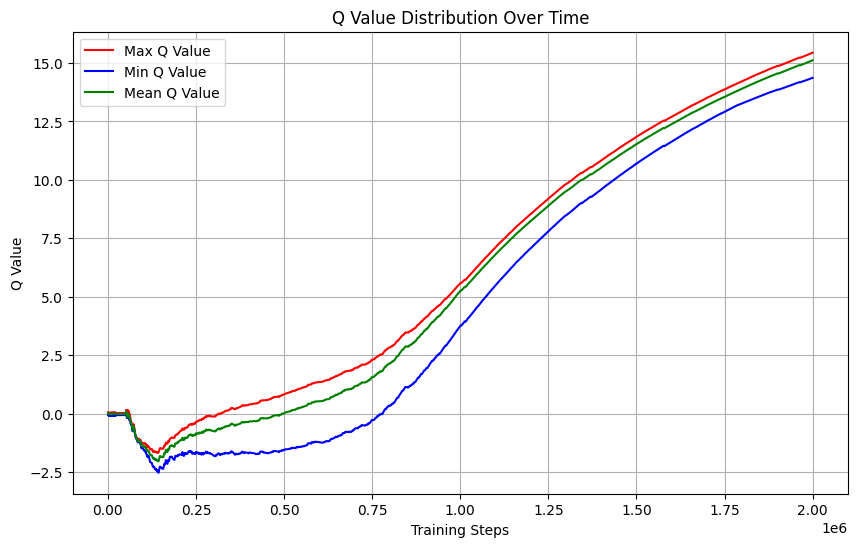

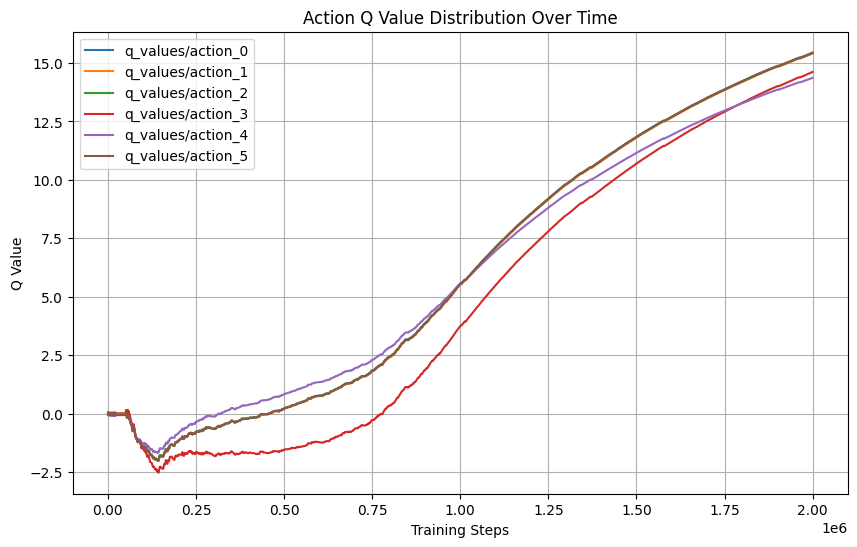

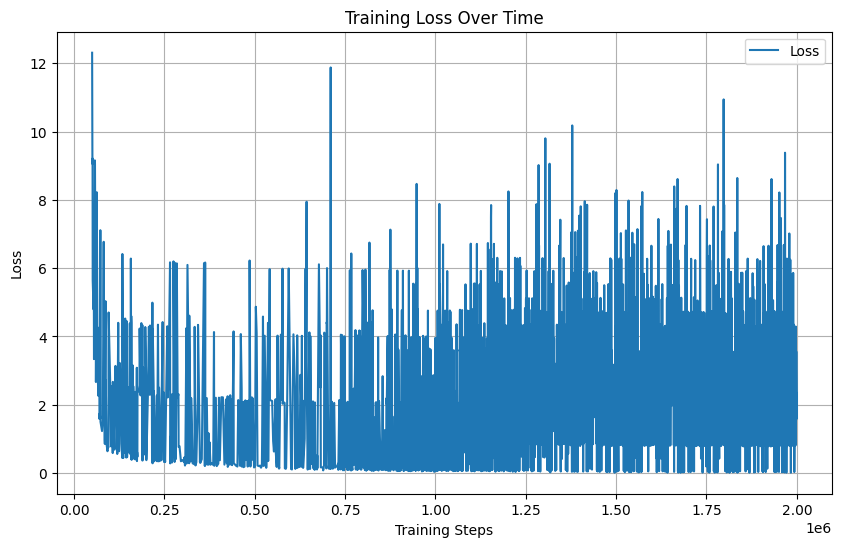

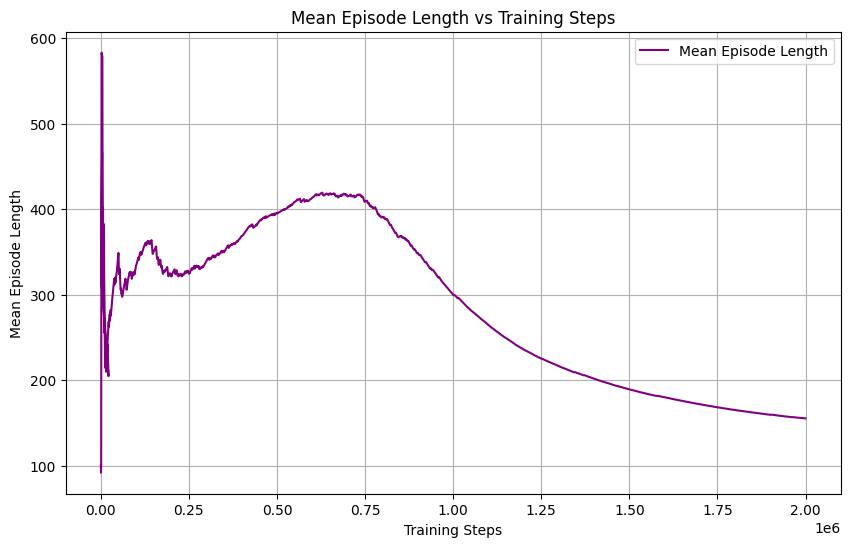

In [80]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# 指定日志文件路径
log_dir = r"C:\Users\raced\Autonomous-Fighter-Jet-Navigation-and-Combat\fighter_jet_dqn_2\DQN_0"
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# 获取所有标量标签
tags = event_acc.Tags()["scalars"]
print("Available scalar tags:", tags)

# 提取某个标量（例如奖励）
if "main/ep_rew_total" in tags:
    rewards = event_acc.Scalars("main/ep_rew_total")
    steps = [x.step for x in rewards]
    values = [x.value for x in rewards]

    # 绘制奖励曲线
    plt.plot(steps, values, label="Episode Reward")
    plt.xlabel("Training Steps")
    plt.ylabel("Reward")
    plt.title("Training Reward Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制探索率 (Epsilon)
if "exploration/epsilon" in tags:
    epsilon = event_acc.Scalars("exploration/epsilon")
    steps = [x.step for x in epsilon]
    values = [x.value for x in epsilon]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label="Epsilon")
    plt.xlabel("Training Steps")
    plt.ylabel("Epsilon")
    plt.title("Epsilon Decay Over Time")
    plt.legend()
    plt.grid()
    plt.show()

# 绘制平均奖励
if "main/ep_rew_total" in tags:
    rewards = event_acc.Scalars("main/ep_rew_total")
    steps = [x.step for x in rewards]
    values = [x.value for x in rewards]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label="Mean Reward")
    plt.xlabel("Training Steps")
    plt.ylabel("Reward")
    plt.title("Mean Reward Over Time")
    plt.legend()
    plt.grid()
    plt.show()

# 绘制 Q 值
if "q_values/mean" in tags:
    q_values = event_acc.Scalars("q_values/mean")
    steps = [x.step for x in q_values]
    values = [x.value for x in q_values]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label="Mean Q Value")
    plt.xlabel("Training Steps")
    plt.ylabel("Q Value")
    plt.title("Mean Q Value Over Time")
    plt.legend()
    plt.grid()
    plt.show()

# 绘制 Q 值分布
if "q_values/max" in tags and "q_values/min" in tags and "q_values/mean" in tags:
    q_max = event_acc.Scalars("q_values/max")
    q_min = event_acc.Scalars("q_values/min")
    q_mean = event_acc.Scalars("q_values/mean")

    steps = [x.step for x in q_max]
    max_values = [x.value for x in q_max]
    min_values = [x.value for x in q_min]
    mean_values = [x.value for x in q_mean]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, max_values, label="Max Q Value", color="red")
    plt.plot(steps, min_values, label="Min Q Value", color="blue")
    plt.plot(steps, mean_values, label="Mean Q Value", color="green")
    plt.xlabel("Training Steps")
    plt.ylabel("Q Value")
    plt.title("Q Value Distribution Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # 绘制动作分布
action_tags = [tag for tag in tags if tag.startswith("q_values/action_")]
if action_tags:
    plt.figure(figsize=(10, 6))
    for action_tag in action_tags:
        action_values = event_acc.Scalars(action_tag)
        steps = [x.step for x in action_values]
        values = [x.value for x in action_values]
        plt.plot(steps, values, label=action_tag)

    plt.xlabel("Training Steps")
    plt.ylabel("Q Value")
    plt.title("Action Q Value Distribution Over Time")
    plt.legend()
    plt.grid()
    plt.show()

# 绘制损失
if "train/loss" in tags:
    losses = event_acc.Scalars("train/loss")
    steps = [x.step for x in losses]
    values = [x.value for x in losses]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label="Loss")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid()
    plt.show()


# 提取 Mean Episode Length 數據
if "main/ep_len_mean" in tags:
    ep_len_mean = event_acc.Scalars("main/ep_len_mean")
    steps = [x.step for x in ep_len_mean]
    values = [x.value for x in ep_len_mean]

    # 繪製 Mean Episode Length vs Steps 圖表
    plt.figure(figsize=(10, 6))
    plt.plot(steps, values, label="Mean Episode Length", color="purple")
    plt.xlabel("Training Steps")
    plt.ylabel("Mean Episode Length")
    plt.title("Mean Episode Length vs Training Steps")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Tag 'main/ep_len_mean' not found in TensorBoard logs.")
    

